# Self-Attention
Found this interesting new idea from https://github.com/sdoria/SimpleSelfAttention. I have been trying to incorporate attention into another model to get better results, so I decided to give this a try and see if it works.

In [1]:
from fastai.vision import *
from fastai.callbacks.tracker import *
%matplotlib inline

### Download dataset
As always we get our images from google. Experimenting with a better way of downloading images, i.e. we feed the url of the google images search result page, this seems to give better photos in the sense that they are more relevant to our query.

In [2]:
from google_images_download import google_images_download
response = google_images_download.googleimagesdownload()

In [3]:
suits = ['spades','hearts','diamonds','clubs']
numbers = ['ace','two','three','four','five','six','seven','eight','nine','ten','jack','queen','king']

In [4]:
args = {'exact_size':"350,350",
        'limit':10,
        'output_directory':'images',
        'silent_mode':True,
        'image_directory': '',
        'prefix':'ace_spades',
        'type':'photo',
       }

We use multiprocessing so things are faster.

In [ ]:
from multiprocessing import Pool

def f(s):
    for n in numbers:
        url = f'https://www.google.com/search?q={n}+of+{s}+poker+card&client=safari&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiGwtjpy7viAhUC148KHdc5DuAQ_AUIDigB&biw=1440&bih=718'
        args['url'] = url
        args['image_directory'] = s
        args['prefix'] = f'{n}_{s}'
        p = response.download(args)
    print(f'Completed download for {s}.')
if __name__ == '__main__':
    p = Pool(4)
    print(p.map(f, suits))

Check for images that are busted and delete them when found.

In [6]:
##A function to recursively get all jpg files in a directory.

def setify(o): return o if isinstance(o,set) else set(listify(o))

def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [7]:
path = Path('./test/')

In [8]:
res = get_files(path,extensions='.jpg',recurse=True)
from PIL import Image

count=0
for r in res:
    try:
        im = Image.open(r)
        im.verify()
    except:
        os.remove(r)
        count+=1
print(f'Removed {count} files.')

Removed 0 files.


### Datablock

In [2]:
path = Path('./')

In [11]:
src = (ImageList.from_folder(path,extensions=['.jpg','.png'],recurse=True,include='images')
        .split_by_rand_pct(seed=42)
        .label_from_folder()
      )

In [12]:
data = (src
        .transform(get_transforms(),size=(224,224))        
        .databunch(bs=15)
        .normalize(imagenet_stats))

In [13]:
data.save()

In [3]:
data=load_data(path)
data.batch_size=20

In [4]:
print(data.classes)
print(data.c)

['clubs', 'diamonds', 'hearts', 'spades']
4


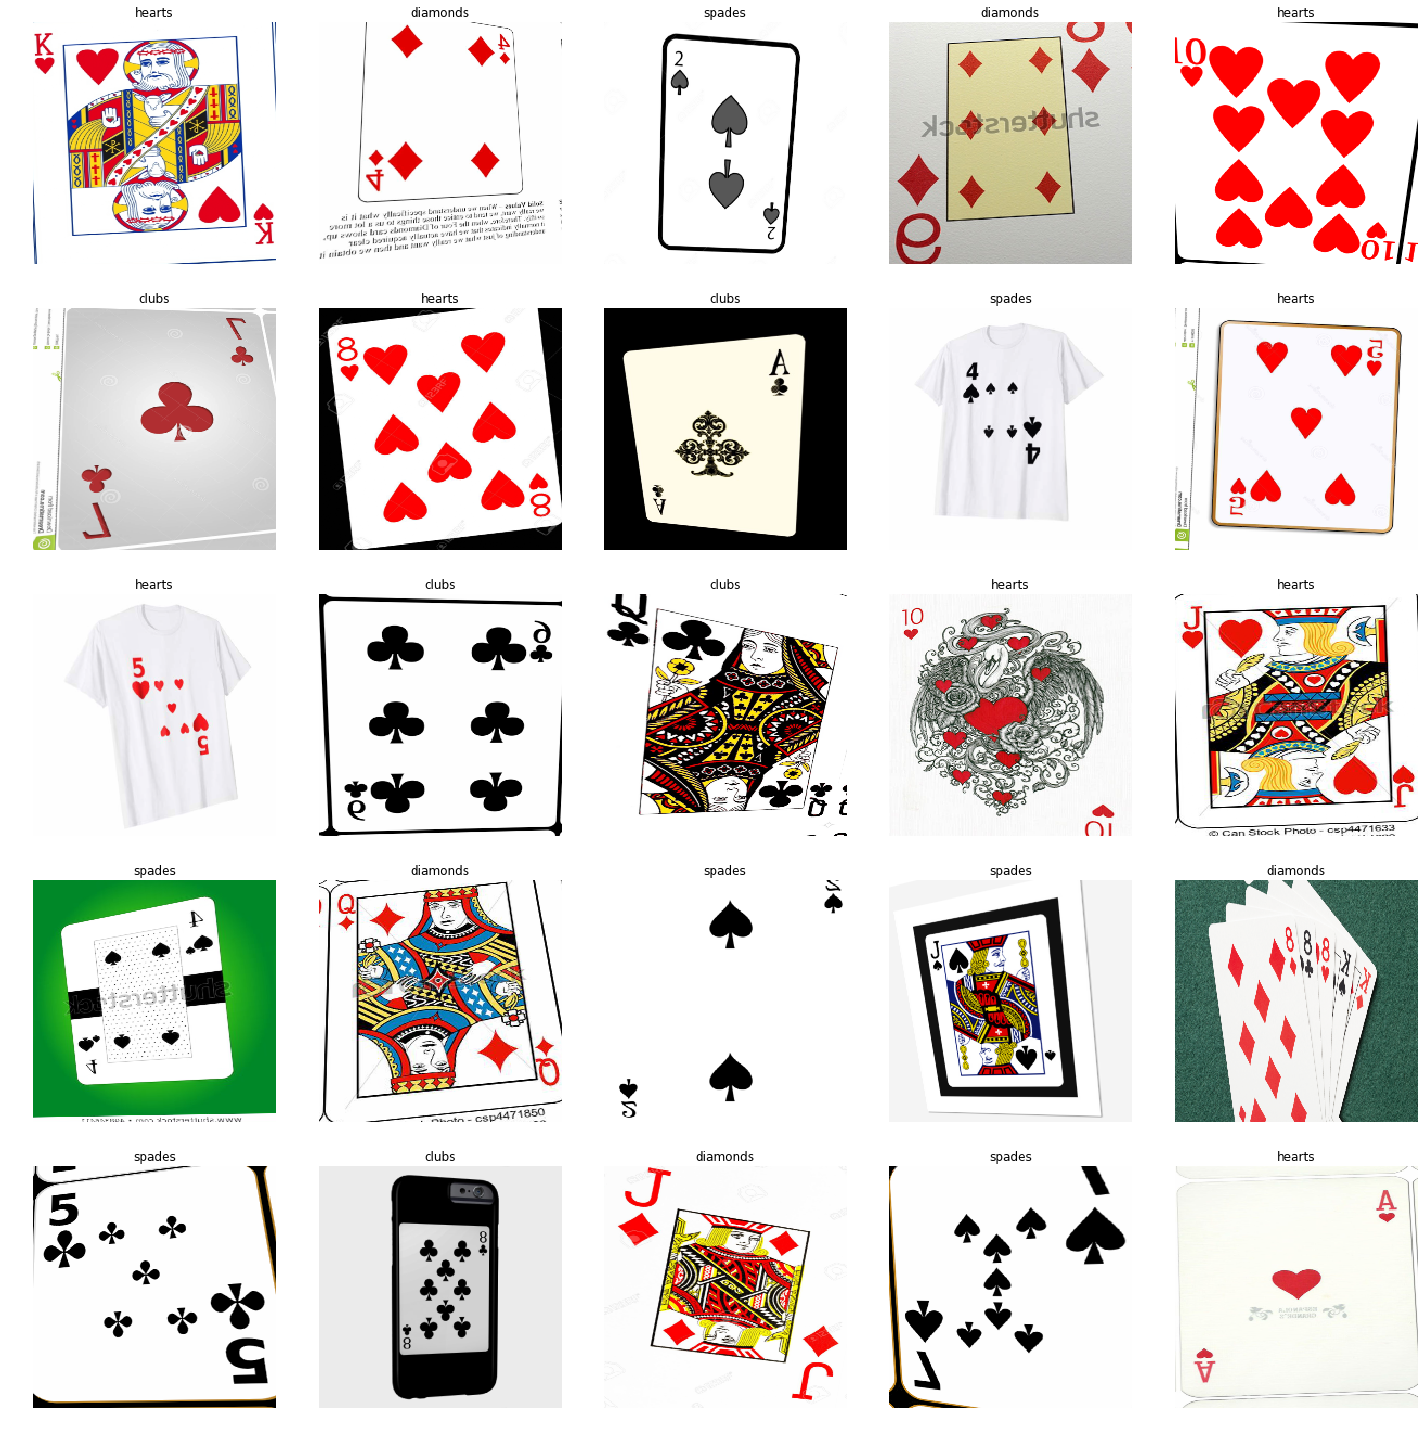

In [16]:
data.show_batch()

Some images are no good, but it's okay we can move on regardless.

### Define architecture

In [5]:
act_fn = nn.ReLU(inplace=True)

In [6]:
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [7]:
#Unmodified from https://github.com/fastai/fastai/blob/5c51f9eabf76853a89a9bc5741804d2ed4407e49/fastai/layers.py
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)

# Adapted from SelfAttention layer at https://github.com/fastai/fastai/blob/5c51f9eabf76853a89a9bc5741804d2ed4407e49/fastai/layers.py
# Inspired by https://arxiv.org/pdf/1805.08318.pdf
class SimpleSelfAttention(nn.Module):
    def __init__(self, n_in:int, ks=1):#, n_out:int):
        super().__init__()
        self.conv = conv1d(n_in, n_in, ks, padding=ks//2, bias=False)
        self.gamma = nn.Parameter(tensor([0.]))
 
    def forward(self,x):
        size = x.size()
        x = x.view(*size[:2],-1)
        w = torch.bmm(x.permute(0,2,1).contiguous(),self.conv(x))
        o = self.gamma * torch.bmm(x,w) + x
        return o.view(*size).contiguous(), w

In [8]:
#unmodified from https://github.com/fastai/fastai/blob/9b9014b8967186dc70c65ca7dcddca1a1232d99d/fastai/vision/models/xresnet.py

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [9]:
# Modified from https://github.com/fastai/fastai/blob/9b9014b8967186dc70c65ca7dcddca1a1232d99d/fastai/vision/models/xresnet.py
# Added self attention
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1,sa=False):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        
        self.sa = sa
        self.attn = SimpleSelfAttention(nf,ks=1) if sa else noop
        
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): 
        # We only return the attn vector for interpretation 
        # we do this so that we can still fit this in nn.Sequential
        if self.sa:
            return act_fn(self.attn(self.convs(x))[0] + self.idconv(self.pool(x)))
        else:
            return act_fn(self.attn(self.convs(x)) + self.idconv(self.pool(x)))

In [10]:
# Modified from https://github.com/fastai/fastai/blob/9b9014b8967186dc70c65ca7dcddca1a1232d99d/fastai/vision/models/xresnet.py
# Added self attention
class XResNet_sa(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2, sa = True if i in[len(layers)-4] else False)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride, sa = False):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, sa if i in [n_blocks -1] else False)
              for i in range(n_blocks)])

In [11]:
def xresnet50_sa (**kwargs): return XResNet_sa.create(4, [3, 4,  6, 3], **kwargs)

In [12]:
#to help prevent cuda memory errors
try:
    del m;gc.collect()
except:
    pass

In [13]:
m = xresnet50_sa(c_out=data.c).cuda()

In [14]:
learn = Learner(data, m, metrics=error_rate)

In [15]:
learn.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

In [16]:
learn.unfreeze()

In [18]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


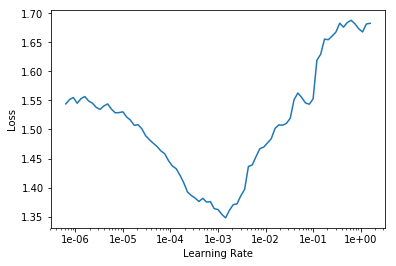

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(20,1e-3,callbacks=[SaveModelCallback(learn,every='improvement',name='1st_224_cards')])

Better model found at epoch 0 with valid_loss value: 1.2726233005523682.
Better model found at epoch 8 with valid_loss value: 0.9085805416107178.
Better model found at epoch 13 with valid_loss value: 0.754219651222229.
Better model found at epoch 14 with valid_loss value: 0.7468152046203613.
Better model found at epoch 15 with valid_loss value: 0.7000190615653992.
Better model found at epoch 16 with valid_loss value: 0.6917850375175476.
Better model found at epoch 17 with valid_loss value: 0.6734710335731506.
Better model found at epoch 18 with valid_loss value: 0.6550053358078003.


### Model Interpretation

In [21]:
learn.load('1st_224_cards');

/home/jupyter/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jupyter/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type XResNet_sa. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jupyter/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jupyter/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SimpleSelfAttention. It won't be checked for correctness upon loading.
  "type " + 

In [22]:
interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

Model gets most of the predictions correct on the validation set, things are looking good.

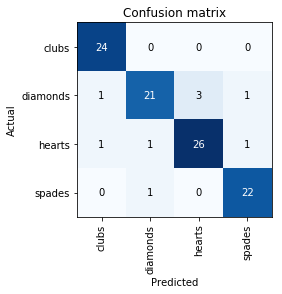

In [23]:
interp.plot_confusion_matrix()

Most of the errors are due to noisy labels, we can easily forgive the model for making these mistakes.

In [24]:
interp.probs = torch.softmax(interp.probs,dim=-1)

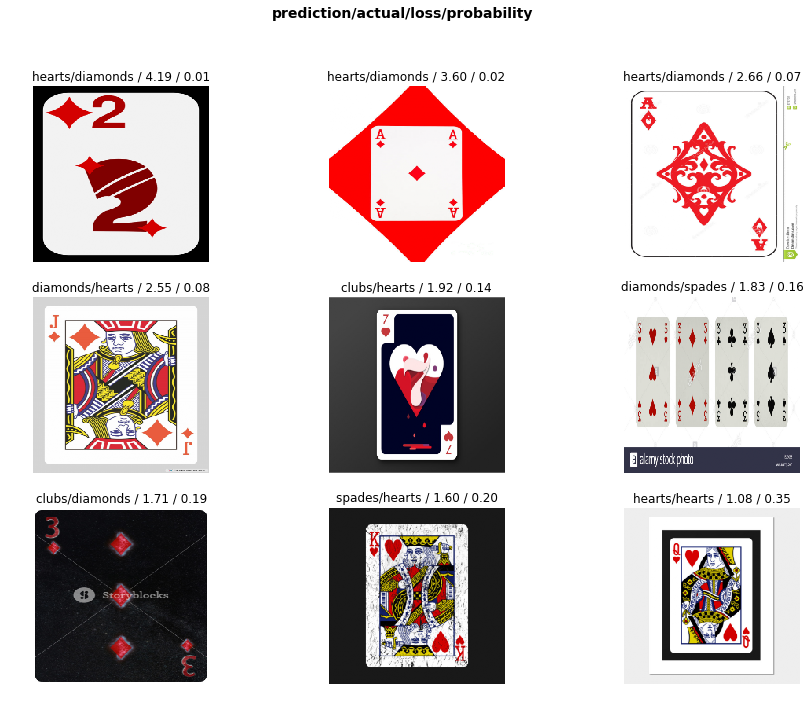

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

### Attention Interpretation
Here comes the fun part, we want to find out where exactly does the model 'look' at while calculating a prediction.

In [26]:
# !wget https://cdn4.vectorstock.com/i/1000x1000/50/23/black-ace-of-hearts-vector-23815023.jpg -O test/black_heart.jpg

In [27]:
import copy
model = copy.deepcopy(m)

In [28]:
model=model.cpu()

We can either load an image from disk, or load an image from the validation set.

In [29]:
# x_im = open_image('test/red_spade.jpg')
x_im  = data.valid_ds.x[1]

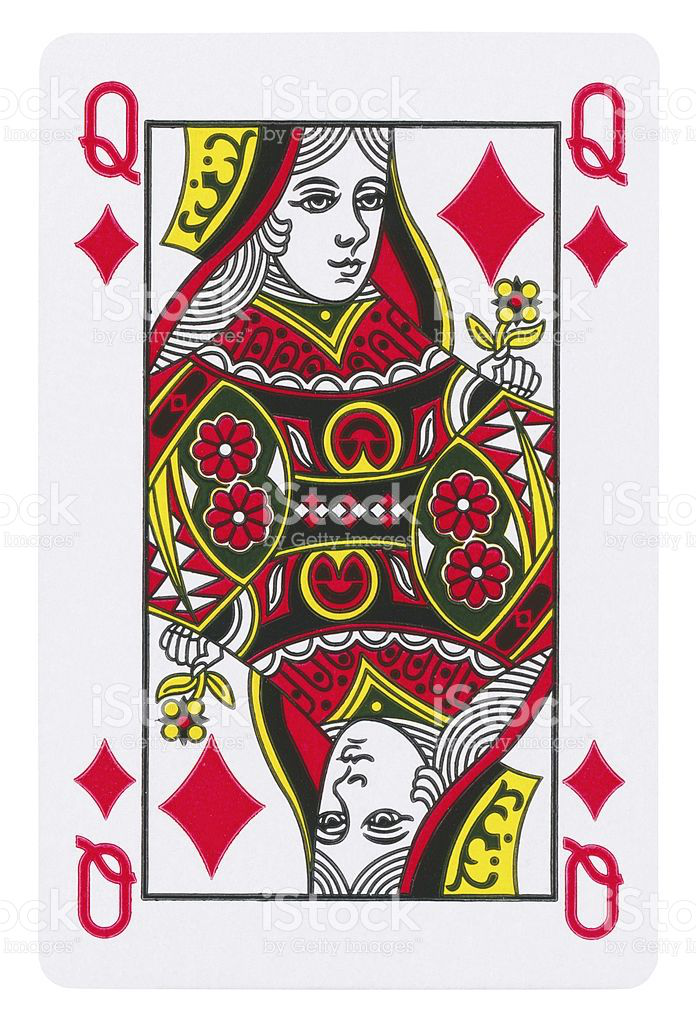

In [30]:
x_im

We convert the image to a tensor that the model accepts as an input.

In [31]:
x = data.one_item(x_im)[0]

Seems to be giving the right prediction.

In [32]:
data.classes

['clubs', 'diamonds', 'hearts', 'spades']

In [34]:
with torch.no_grad():
    res = model(x.cpu())
print(data.classes[res.argmax(-1)])

diamonds


We attach a hook to the attention activation from the Self-Attention layer so we can retrieve the activations.

In [35]:
from fastai.callbacks.hooks import *

In [36]:
def hook_attention():
    with hook_output(model[4][2].attn) as hook_sa: 
        res = model(x.cpu())        
        return hook_sa

In [37]:
h = hook_attention()

In [38]:
attn = h.stored[1]

We calculate the mean weights for each pixel on the N * N attention grid. Then we scale it so its between 0 and 1.

In [39]:
attn = attn.mean(dim=1).transpose(1,0)

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
res = scaler.fit_transform(attn)

Reshape it back to the dims of a square image. (We are assuming we are working with square tensors!)

In [41]:
hw = int(np.sqrt(attn.shape[0]))

In [42]:
attn = attn.view(hw,hw)

In [43]:
sz = list(x_im.shape[-2:])

Voila, the model seems to have its eyes on the right places!

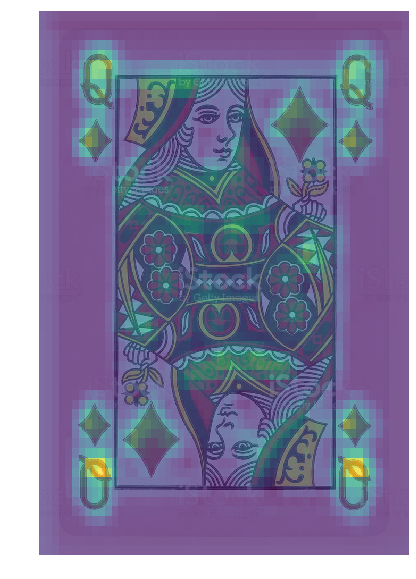

In [45]:
_,ax = plt.subplots(1,1, figsize=(10,10))
x_im.show(ax=ax)
ax.imshow(attn, cmap='viridis', interpolation='nearest',alpha=0.7,extent=(0,*sz[::-1],0))

# END